In [107]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import average_precision_score, auc, precision_recall_curve
from pathlib import Path
from bicycle.utils.mask_utils import get_mask2, get_sparsity, add_saltpepper, normalize_matrix, above_threshold, add_noise
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import expit
data_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/scMultiSim_data/")
run_id = "data_run003"
data_path /= run_id
save = False

In [108]:
def get_mask2(atac,
             region_to_gene,
             region_to_tf,
             threshold = False,
             percentile : int = 50,
             correlation = False,
             corr_normalize = False,
             corr_threshold = False,
             corr_threshold_percentile: int = 50,
             pseudocounts = False,
             ):
    """
    Args:
    atac (np.array): regions x samples
    params (dict): function parameters
    """
    if pseudocounts:
        atac += np.min(atac)*0.0001
    if correlation and atac.shape[1]>1:
        corr_atac = np.abs(np.corrcoef(atac))
        #plt.imshow(corr_atac)
        if corr_normalize:
#            print("norm")
            corr_atac = normalize_matrix(corr_atac)
        if corr_threshold:
#            print("threshold")
            corr_atac = above_threshold(corr_atac, corr_threshold_percentile)
    else:
        corr_atac = atac @ atac.T
    mask = region_to_gene.T @ corr_atac @ region_to_tf
    if threshold:
        mask = above_threshold(mask, percentile)
    return mask


In [125]:
def get_precision(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    #beta[beta<0] = 0
    beta = expit(beta)
    average_precision = average_precision_score(grn, beta)
    return average_precision
def get_auprc(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    #beta[beta<0] = 0
    beta = expit(beta)
    p,r,t = precision_recall_curve(grn, beta)
    auprc = auc(r,p)
    return auprc
def apply_pca(data_profile:dict, n_comp=None, mask=[]):
    new_profile = data_profile.copy()
    atac = new_profile["atac"]
    pca = PCA(svd_solver="full").fit(atac)
    atac=pca.transform(atac)
    if len(mask) >0:
        atac[:,mask] = 0
    if n_comp!= None:
        atac[:, n_comp:] = 0
    #print(np.min(atac, axis=None))
    #atac = atac + np.abs(np.min(atac, axis=None))
    atac = pca.inverse_transform(atac)
    new_profile["atac"]= atac
    return new_profile

In [110]:
atac_base = pd.read_csv(data_path/"processed_atac.csv", index_col=0).to_numpy(np.float32).T
grn = pd.read_csv(data_path/"unperturbed_data"/"geff.csv", index_col=0).to_numpy(np.float32)
region_to_gene = pd.read_csv(data_path/"unperturbed_data"/"region_to_gene.csv", index_col=0).to_numpy(np.float32)
region_to_tf = pd.read_csv(data_path/"unperturbed_data"/"region_to_tf.csv", index_col=0).to_numpy(np.float32)

grn[grn <= 1.0000000e-06] =0

In [111]:
base_data = {"atac":atac_base[:,:8000],
             "region_to_gene":region_to_gene,
             "region_to_tf": region_to_tf,
             }

In [112]:
# Forward selection
def for_select(grn, data, _parameters, _baseline_prec = 0, _a=[], _p=[], eval = get_precision, mask_func = get_mask2, plot = False):
    if _baseline_prec == 0:
        if plot:
            _p=list()
            _a = list()
        mask = mask_func(**data, **_parameters)
        _baseline_prec = eval(grn, mask)
        #print(_baseline_prec)
    precisions = []
    for key, value in _parameters.items():

        if value:
            precisions.append(0)
            continue
        if not type(value) is bool:
            precisions.append(0)
            continue
        params = _parameters.copy()
        params[key] = True
        mask = mask_func(**data, **params)
        precisions.append(eval(grn, mask))
    
    #print(precisions)
    #print(_parameters)
    max_prec = np.max(precisions)
    if max_prec <= _baseline_prec:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            plt.imshow(mask_func(**data, **_parameters))
        return _parameters, _baseline_prec
    argmax = np.argmax(precisions)
    maxkey = [n for n in _parameters.keys()][argmax]
    _parameters[maxkey] = True
    if plot:
        _p.append(max_prec)
        _a.append(maxkey)
        #print(_a,_p)
    return for_select(grn, data, _parameters, max_prec,_a=_a, _p=_p, eval=eval)
# Reverse selection
def rev_select(grn, data, _parameters, _baseline_prec = 0, _a=[], _p=[], eval = get_precision, mask_func = get_mask2, plot = False):
    if _baseline_prec == 0:
        mask = mask_func(**data, **_parameters)
        _baseline_prec = eval(grn, mask)
        #print(_baseline_prec)
    precisions = []
    keys = []
    for key, value in _parameters.items():

        if not value:
            continue
        if not type(value) is bool:
            continue
        params = _parameters.copy()
        params[key] = False
        mask = mask_func(**data, **params)
        precisions.append(eval(grn, mask))
        keys.append(key)
    #print(f"precisions: {precisions}")
    #print(f"keys: {keys}")
    if len(precisions) ==0:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            plt.imshow(mask_func(**data, **_parameters))
        #max_prec = eval(grn,mask_func(**data, **_parameters))
        return _parameters, _baseline_prec
    max_prec = np.max(precisions)
    if max_prec <= _baseline_prec:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            plt.imshow(mask_func(**data, **_parameters))
        return _parameters, _baseline_prec
    argmax = np.argmax(precisions)
    maxkey = keys[argmax]
    _parameters[maxkey] = False
    if plot:
        _p.append(max_prec)
        _a.append(maxkey)
        #print(f"_p: {_p}")
        #print(f"_a: {_a}")
    return rev_select(grn, data, _parameters, max_prec,_a=_a, _p=_p, eval=eval)


In [113]:
threshold = 80

rev_parameters = {
    "threshold" : True,
    "percentile" : threshold,
    "correlation" : True,
    "corr_normalize" : True,
    "corr_threshold" : True,
    "corr_threshold_percentile" : threshold,
    "pseudocounts" : True,
    }

for_parameters = {
    "threshold" : False,
    "percentile" : threshold,
    "correlation" : False,
    "corr_normalize" : False,
    "corr_threshold" : False,
    "corr_threshold_percentile" : threshold,
    "pseudocounts" : False,
    }
print(threshold)
for_select(grn=grn,data =  base_data, _parameters= for_parameters)


80


({'threshold': False,
  'percentile': 80,
  'correlation': True,
  'corr_normalize': True,
  'corr_threshold': False,
  'corr_threshold_percentile': 80,
  'pseudocounts': False},
 0.7129508999998679)

In [173]:
# increase noise on the region matrices
repeats = 3
step = 0.1
max = 1.1
rev_results = np.empty((int(max/step), len(rev_parameters.values()), repeats))
for_results = np.empty((int(max/step), len(for_parameters.values()), repeats))
for r in range(repeats):
    print(f"r: {r}")
    for n, p in enumerate(np.arange(0,max, step)):
        print(f"p: {p}")
        region_to_gene = add_saltpepper(base_data["region_to_gene"].copy(), p=p)
        region_to_tf = add_saltpepper(base_data["region_to_tf"].copy(), p=p)

        atac = base_data["atac"].copy()
        # center and scale
        atac = np.subtract(atac, np.mean(atac, axis=1, keepdims=True))
        atac = np.divide(atac, np.std(atac, axis=1, keepdims=True))
        data = {
            "atac":atac,
            "region_to_gene":region_to_gene,
            "region_to_tf":region_to_tf
        }
        
        #rev_parameters["corr_threshold_percentile"] = p
        #rev_parameters["percentile"] =p
        #data = base_data.copy()
        base_prec = get_precision(grn, get_mask2(**data, **rev_parameters))
        params, max_prec= rev_select(grn=grn.copy(),data=data.copy(),_parameters=rev_parameters.copy(), eval=get_precision)
        #print(params.values())
        del params["percentile"]
        del params["corr_threshold_percentile"]
        #print(max_prec)
        #print(base_prec)
        #for_parameters["corr_threshold_percentile"] = p
        #for_parameters["percentile"] =p
        rev_results[n,:, r] = np.append([max_prec, base_prec], list(params.values()))
        base_prec = get_precision(grn, get_mask2(**data, **for_parameters))
        params, max_prec= for_select(grn=grn.copy(),data=data.copy(),_parameters=for_parameters.copy(), eval=get_precision)
        #print(params.values())
        del params["percentile"]
        del params["corr_threshold_percentile"]
        #print(max_prec)
        #print(base_prec)
        for_results[n,:, r] = np.append([max_prec, base_prec], list(params.values()))

r: 0
p: 0.0
p: 0.1
p: 0.2
p: 0.30000000000000004
p: 0.4
p: 0.5
p: 0.6000000000000001
p: 0.7000000000000001
p: 0.8
p: 0.9
p: 1.0
r: 1
p: 0.0
p: 0.1
p: 0.2
p: 0.30000000000000004
p: 0.4
p: 0.5
p: 0.6000000000000001
p: 0.7000000000000001
p: 0.8
p: 0.9
p: 1.0
r: 2
p: 0.0
p: 0.1
p: 0.2
p: 0.30000000000000004
p: 0.4
p: 0.5
p: 0.6000000000000001
p: 0.7000000000000001
p: 0.8
p: 0.9
p: 1.0


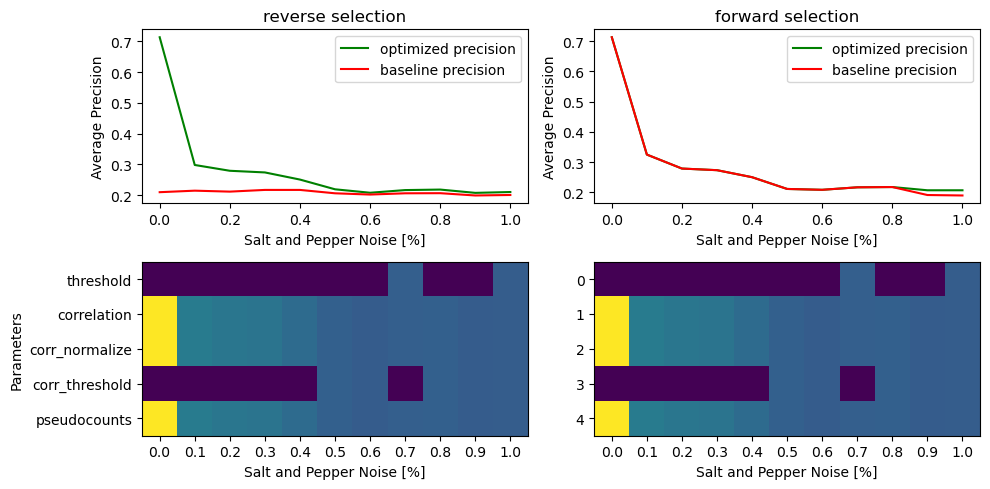

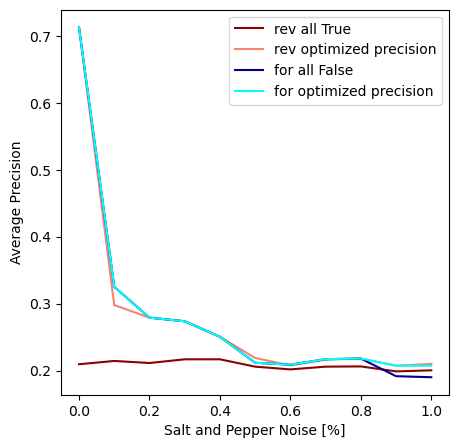

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
labels = ["threshold",
    #"percentile",
    "correlation",
    "corr_normalize",
    "corr_threshold",
    #"corr_threshold_percentile",
    "pseudocounts"]
plt.subplot(2,2,1)
plt.plot(np.arange(0,max,step),np.median(rev_results[:,0], axis=1), c="g", label = "optimized precision")
plt.plot(np.arange(0,max,step),np.median(rev_results[:,1], axis=1), c="r", label = "baseline precision")
plt.title(f"reverse selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.subplot(2,2,2)
plt.plot(np.arange(0,max,step),np.median(for_results[:,0], axis=1), c="g", label = "optimized precision")
plt.plot(np.arange(0,max,step),np.median(for_results[:,1], axis=1), c="r", label = "baseline precision")
plt.title(f"forward selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")

plt.subplot(2,2,3)

rev_precision = np.median(rev_results[:,0], axis=1)
rev_results_median = np.median(rev_results[:,2:], 2)
rev_weighted_results =rev_results_median* rev_precision.repeat(rev_results_median.shape[1]).reshape(rev_results_median.shape)

plt.imshow(rev_weighted_results.T, aspect="auto", interpolation="nearest")
ticks, _ = plt.yticks()

plt.yticks(ticks[1:-1], labels)
plt.xticks(ticks = np.arange(0,11, 1).astype(int),labels = np.arange(0, max, step).round(2))
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Parameters")
plt.subplot(2,2,4)

for_precision = np.median(for_results[:,0], axis=1)
for_results_median = np.median(for_results[:,2:], 2)

for_weighted_results =for_results_median* for_precision.repeat(for_results_median.shape[1]).reshape(for_results_median.shape)

plt.imshow(rev_weighted_results.T, aspect="auto", interpolation="nearest")
plt.xticks(ticks = np.arange(0,11, 1).astype(int),labels = np.arange(0, max, step).round(2))
plt.xlabel("Salt and Pepper Noise [%]")
plt.tight_layout()
if save:
    plt.savefig("../presentation/masksel_params_tableau.pdf")
plt.rcParams["figure.figsize"] = (5, 5)
plt.show()
plt.plot(np.arange(0,max,step),np.median(rev_results[:,1], axis=1), c="darkred", label = "rev all True")
plt.plot(np.arange(0,max,step),rev_precision, c="salmon", label = "rev optimized precision")
plt.plot(np.arange(0,max,step),np.median(for_results[:,1], axis=1), c="darkblue", label = "for all False")
plt.plot(np.arange(0,max,step),for_precision, c="aqua", label = "for optimized precision")
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.legend()
if save:
    plt.savefig("../presentation/masksel_params_curves.pdf")

In [116]:
# get the maximum set:
argmax = np.argmax(for_results[:,0])
params=np.mean(for_results[argmax, 2:], axis=1)
parameters = for_parameters.copy()
n=0
for key, value in parameters.items():
    if type(value)!= bool:
        continue
    else:
        parameters[key] = params[n] >0.5
        n+=1
print(parameters)

{'threshold': False, 'percentile': 80, 'correlation': True, 'corr_normalize': True, 'corr_threshold': False, 'corr_threshold_percentile': 80, 'pseudocounts': False}


In [155]:
# select for PCs
def for_PCs(grn,
            data,
            parameters,
            n_comp,
            eval = get_precision,
            mask_func = get_mask2,
            cumulative = False,
            svd_solver="arpack",
            plot = False,
            _PCs = None,
            _baseline_prec = 0,
            _a=None, _p=None,
            transform = None,
            pca=None,
            ):
    if _PCs is None:
        _PCs = np.full(n_comp, fill_value=False)
    if _a is None:
        _a = []
        _p = []

    if _baseline_prec == 0 and transform==None:
        print("Forward Selection:")
        #print("Starting")
        if plot:
            _p=list()
            _a = list()

        atac=data["atac"]
        pca = PCA(n_components=n_comp, svd_solver=svd_solver).fit(atac)
        transform = pca.transform(atac)
        mask = mask_func(**data, **parameters)
        _baseline_prec = eval(grn, mask)
        print(f"baseline precision: {_baseline_prec}")

    precisions = []
    for n in range(n_comp):
        #print(n)
        if cumulative:
            if n ==0:
                precisions.append(0)
                continue
            _transform = transform.copy()
            _transform[:,n:] = 0
            mask = mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters)
            precisions.append(eval(grn, mask))
            continue
        if _PCs[n]:
            precisions.append(0)
            continue
        if np.sum(_PCs) == 0:
            #print("First PC")
            _transform = transform.copy()
            _transform[:, n:n+1] = 0
            mask = mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters)
            ##print(mask.shape)
            precisions.append(eval(grn, mask))
            continue

        PCs = _PCs.copy()
        PCs[n] = True
        ##print(f"Shape of atac pca: {data['atac'][:, PCs].shape}")
        _transform=transform
        _transform[:, PCs] = 0
        mask = mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters)
        ##print(eval(grn, mask))
        precisions.append(eval(grn, mask))
    
    #print(precisions)
    ##print(parameters)
    max_prec = np.max(precisions)
    print(f"max_precision: {max_prec}")

    argmax = np.argmax(precisions)
    if cumulative:
        if max_prec < _baseline_prec:
            print("PCA results in precision loss!")
#            return np.full(shape=n_comp, fill_value=False).tolist(), _baseline_prec
        return [n < argmax for n in range(n_comp)], max_prec
    if _baseline_prec>max_prec:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            _transform=transform.copy()
            _transform[:, _PCs] = 0
            plt.imshow(mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters))
        return _PCs, _baseline_prec
    _PCs[argmax] = True
    
    #print(_PCs)

    if plot:
        _p.append(max_prec)
        _a.append(argmax)
    #    print(_a,_p)
    return for_PCs(grn=grn,
        data=data,
        parameters=parameters,
        n_comp=n_comp,
        cumulative=cumulative,
        _PCs=_PCs,
        _baseline_prec = max_prec,
        _a=_a,
        _p=_p,
        eval=eval,
        transform=transform,
        pca=pca,
        plot=plot
        )



def rev_PCs(grn,
            data,
            parameters,
            n_comp,
            eval = get_precision,
            mask_func = get_mask2,
            svd_solver="arpack",
            plot = False,
            _PCs = [],
            _baseline_prec = 0,
            _a=[], _p=[],
            transform=None,
            pca = None,
            cumulative = False
            ):
    if _baseline_prec == 0 and transform==None:
        print("Reverse Selection:")
        #print("Starting")
        if plot:
            _p=list()
            _a = list()
        _PCs = np.full(n_comp, True)
        atac=data["atac"]
        pca = PCA(n_components=n_comp, svd_solver=svd_solver).fit(atac)
        transform = pca.transform(atac)
        mask = mask_func(**data, **parameters)
        print(f"baseline precision: {eval(grn, mask)}")
        
    precisions = []
    for n in range(n_comp):
        ##print(n)
        if cumulative:
            if n ==0:
                precisions.append(0)
                continue
            _transform = transform.copy()
            _transform[:,:n] = 0
            mask = mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters)
            precisions.append(eval(grn, mask))
            continue
        if np.sum(_PCs)==0:
            print("No PCs left")
            precisions = [0]
            break
        if not _PCs[n]:
            precisions.append(0)
            continue

        PCs = _PCs.copy()
        PCs[n] = False
        ##print(f"Shape of atac pca: {data['atac'][:, PCs].shape}")
        _transform= transform.copy()
        _transform[:, PCs] = 0
        mask = mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters)
        ##print(eval(grn, mask))
        precisions.append(eval(grn, mask))
    
    ##print(len(precisions))
    ##print(parameters)
    max_prec = np.max(precisions)
    print(f"max_precision: {max_prec}")

    argmax = np.argmax(precisions)
    if cumulative:
        if max_prec < _baseline_prec:
            print("PCA results in precision loss!")
#            return np.full(shape=n_comp, fill_value=False).tolist(), _baseline_prec
        return [n > argmax for n in range(n_comp)], max_prec
    
    if _baseline_prec>max_prec:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            _transform=transform.copy()
            _transform[:, _PCs] = 0
            plt.imshow(mask_func(atac = pca.inverse_transform(_transform),
                         region_to_gene = data["region_to_gene"],
                         region_to_tf = data["region_to_tf"],
                         **parameters))
        return _PCs, _baseline_prec

    _PCs[argmax] = False
    if plot:
        _p.append(max_prec)
        _a.append(argmax)
        #print(_a,_p)
    return rev_PCs(grn=grn,
        data=data,
        parameters=parameters,
        n_comp=n_comp,
        _PCs=_PCs,
        _baseline_prec = max_prec,
        _a=_a,
        _p=_p,
        eval=eval,
        transform=transform,
        pca =  pca,
        plot=plot)

In [129]:

for_PCs(grn=grn,
        data=base_data,
        parameters=parameters,
        n_comp=329,
        eval = get_precision,
        cumulative = True,
        plot = True,
        )

baseline precision: 0.7129508999998679
max_precision: 0.704954209470996
PCA results in precision loss!


([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


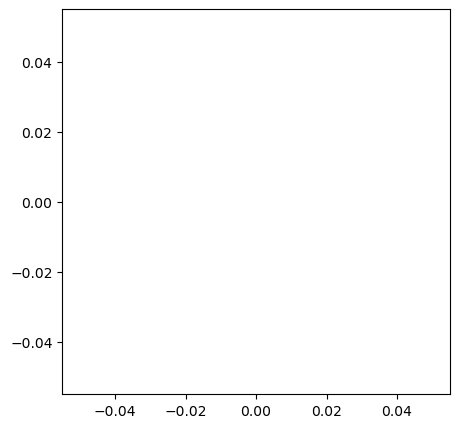

In [119]:
from scipy.stats.distributions import norm
x = np.linspace(-5, 5, 1000)
plt.plot(x, norm(loc=0, scale=0).pdf(x))

In [177]:
# increase noise on the region matrices
repeats = 1
step = 0.1
max = 1
max += step
n_comp= 100
cum = False
rev =True
svd_solver = "arpack"
pc_params=parameters
rev_results = np.empty((int(max/step), n_comp+2, repeats))
for_results = np.empty((int(max/step), n_comp+2, repeats))
for r in range(repeats):
    print(f"Repeat: {r}")
    for n, p in enumerate(np.arange(0,max, step)):
        print(f"Noise: {p}")
        region_to_gene = base_data["region_to_gene"].copy()
        region_to_gene = add_saltpepper(region_to_gene, p=p)
        region_to_tf = base_data["region_to_tf"].copy()
        region_to_tf = add_saltpepper(region_to_tf, p=p)
        #plt.imshow(region_to_gene)
        #plt.show()
        #plt.imshow(region_to_tf)        
        #plt.show()
        atac = base_data["atac"].copy()
        # center and scale
        atac = np.subtract(atac, np.mean(atac, axis=1, keepdims=True))
        atac = np.divide(atac, np.std(atac, axis=1, keepdims=True))
        # add noise
        #atac = atac+np.random.normal(loc=0, scale=p, size=base_data["atac"].shape)
        data = {
            "atac":atac,
            "region_to_gene":region_to_gene,
            "region_to_tf":region_to_tf
        }
        if cum or rev:
            PCs, max_prec= rev_PCs(grn.copy(), data.copy(), pc_params.copy(), eval=get_precision, n_comp=n_comp, svd_solver=svd_solver, cumulative=cum)
            #data_sub= apply_pca(data.copy(), n_comp)
            #print(max_prec)
            base_prec = get_precision(grn, get_mask2(**data, **pc_params))
            #print(base_prec)
            rev_results[n,:, r] = np.append([max_prec, base_prec], PCs)

        PCs, max_prec= for_PCs(grn.copy(), data.copy(), pc_params.copy(), eval=get_precision, n_comp=n_comp, cumulative=cum, svd_solver=svd_solver)
        #data_sub= apply_pca(data.copy(), n_comp)
        #print(max_prec)
        base_prec = get_precision(grn, get_mask2(**data, **pc_params))
        #print(base_prec)
        for_results[n,:, r] = np.append([max_prec, base_prec], PCs)

Repeat: 0
Noise: 0.0
Reverse Selection:
baseline precision: 0.7129508999998679
max_precision: 0.302290314614699
max_precision: 0.3153531700875549
max_precision: 0.3233522799944293
max_precision: 0.3269727156572601
max_precision: 0.3342506108585189
max_precision: 0.33888628590208913
max_precision: 0.34468670311503224
max_precision: 0.35349307650028405
max_precision: 0.35882033316722173
max_precision: 0.36600037748840786
max_precision: 0.37079616375710944
max_precision: 0.3729370833178134
max_precision: 0.3817875985800122
max_precision: 0.3842972308892911
max_precision: 0.38468372160895836
max_precision: 0.38634355773198825
max_precision: 0.3897947227854571
max_precision: 0.3892558534087379
Forward Selection:
baseline precision: 0.7129508999998679
max_precision: 0.4469148951184426
Noise: 0.1
Reverse Selection:
baseline precision: 0.3140332641356195
max_precision: 0.2604307376929975
max_precision: 0.26410035234110785
max_precision: 0.26716657691225587
max_precision: 0.27060232561784625
ma

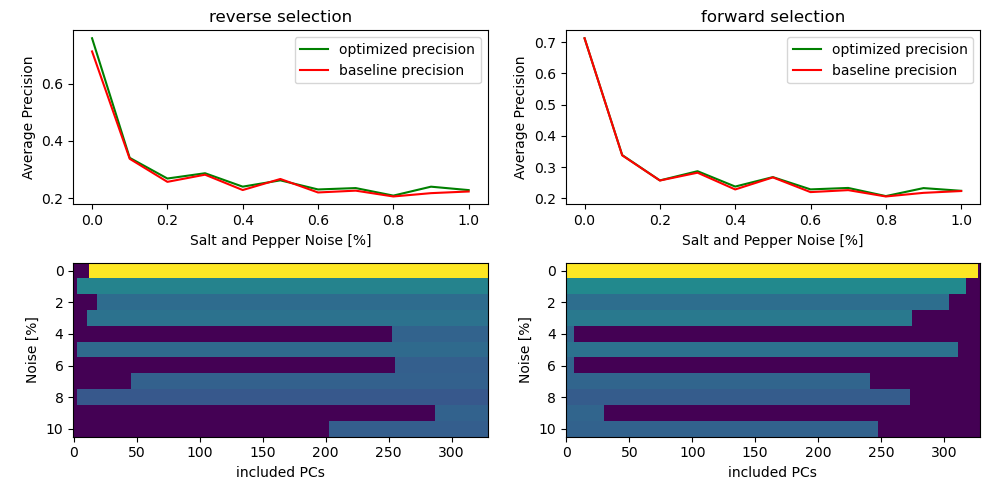

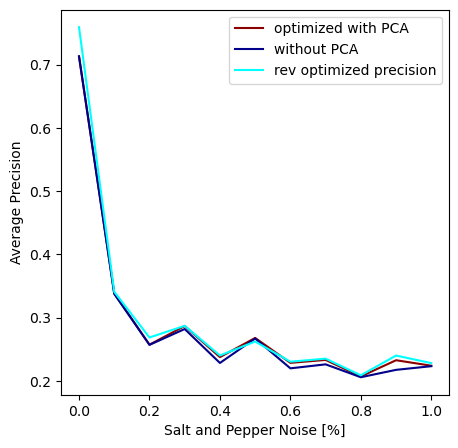

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
labels = np.arange(n_comp)
plt.subplot(2,2,1)
plt.plot(np.arange(0,max,step),np.mean(rev_results[:,0], axis=1), c="g", label = "optimized precision")
plt.plot(np.arange(0,max,step),np.mean(rev_results[:,1], axis=1), c="r", label = "baseline precision")
#plt.bar(np.arange(0,max,step),np.sum(np.median(rev_results[:,2:], axis=2), axis=1) / 330, color="b", label= "PC count",alpha=0.1)
plt.title(f"reverse selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.subplot(2,2,2)
plt.plot(np.arange(0,max,step),np.mean(for_results[:,0], axis=1), c="g", label = "optimized precision")
plt.plot(np.arange(0,max,step),np.mean(for_results[:,1], axis=1), c="r", label = "baseline precision")
plt.title(f"forward selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")

plt.subplot(2,2,3)

rev_precision = np.median(rev_results[:,0], axis=1)
rev_results_median = np.median(rev_results[:,2:], axis=2)
rev_weighted_results =rev_results_median* rev_precision.repeat(rev_results_median.shape[1]).reshape(rev_results_median.shape)

plt.imshow(rev_weighted_results, aspect="auto", interpolation="nearest")
plt.xlabel("included PCs")
plt.ylabel("\nNoise [%]")
ticks, _ = plt.yticks()

#plt.yticks(ticks[1:-1], labels)

plt.subplot(2,2,4)

for_precision = np.median(for_results[:,0], axis=1)
for_results_median = np.median(for_results[:,2:], axis=2)

for_weighted_results =for_results_median* for_precision.repeat(for_results_median.shape[1]).reshape(for_results_median.shape)

plt.imshow(for_weighted_results, aspect="auto", interpolation="nearest")
plt.xlabel("included PCs")
plt.ylabel("\nNoise [%]")
plt.tight_layout()
if save:
    plt.savefig("../presentation/masksel_pcs_tableau.pdf")
plt.show()
plt.rcParams["figure.figsize"] = (5, 5)

#plt.plot(np.arange(0,max,step),np.mean(rev_results[:,1], axis=1), c="darkred", label = "rev all True")
plt.plot(np.arange(0,max,step),np.mean(for_results[:,0], axis=1), c="darkred", label = "optimized with PCA")
plt.plot(np.arange(0,max,step),np.mean(for_results[:,1], axis=1), c="darkblue", label = "without PCA")
plt.plot(np.arange(0,max,step),np.mean(rev_results[:,0], axis=1), c="aqua", label = "rev optimized precision")
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.legend()
if save:
    plt.savefig("../presentation/masksel_pca_curves.pdf")

In [ ]:
rev_weighted_results

array([[0.71285951, 0.71285951, 0.71285951, ..., 0.71285951, 0.        ,
        0.        ],
       [0.27628036, 0.27628036, 0.27628036, ..., 0.27628036, 0.27628036,
        0.        ],
       [0.31821219, 0.31821219, 0.31821219, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.20325723, 0.20325723, 0.20325723, ..., 0.        , 0.        ,
        0.        ],
       [0.24316288, 0.24316288, 0.24316288, ..., 0.        , 0.        ,
        0.        ],
       [0.20865818, 0.20865818, 0.20865818, ..., 0.        , 0.        ,
        0.        ]])

In [141]:
for n in base_data.values():
    print(n.shape)
    print(np.mean(n, axis=1).shape)

(330, 8000)
(330,)
(330, 110)
(330,)
(330, 5)
(330,)


In [ ]:

trunc_data = base_data.copy()
trunc_data["atac"] = trunc_data["atac"]
#data = apply_pca(trunc_data, n_comp=None)
mask = get_mask2(**trunc_data, **for_parameters)
baseline = get_precision(grn, mask)
data = apply_pca(trunc_data, n_comp=None)
mask = get_mask2(**data, **for_parameters)
print(baseline)
print(get_precision(grn, mask))


In [126]:
base_precisions = []
precisions = []
x = np.arange(0, 330, 10)
for n in x:
    trunc_data = base_data.copy()
    trunc_data["atac"] = trunc_data["atac"]
    #data = apply_pca(trunc_data, n_comp=None)
    mask = get_mask2(**trunc_data, **parameters)
    baseline = get_precision(grn, mask)
    data = apply_pca(trunc_data, n_comp=n)
    mask = get_mask2(**data, **parameters)
    base_precisions.append(baseline)
    precisions.append(get_precision(grn, mask))
print(precisions)

[0.22895526607872738, 0.2897898470783022, 0.3047719872726921, 0.322963312741262, 0.3369153867814869, 0.34001800760705914, 0.3461661436635926, 0.3661802179209178, 0.3769434952412837, 0.39336078865754187, 0.40604202656715416, 0.4106969470312535, 0.4156273254485276, 0.4347963505986579, 0.45018510025519776, 0.4617288181576889, 0.46499245286316127, 0.47495199454369946, 0.48405613578993995, 0.4882759822626848, 0.4915839152316337, 0.5097520317568619, 0.523444926421352, 0.536422139914717, 0.542852886817251, 0.5484694139854707, 0.5588077967165355, 0.5751038525803298, 0.5963570441954534, 0.610829901215967, 0.6265854138716419, 0.6429612060561797, 0.6721732099094351]


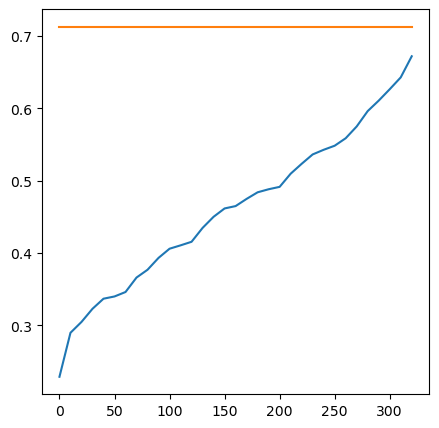

In [127]:
plt.plot(x,precisions)
plt.plot(x,base_precisions)

In [ ]:
np.sum(rev_results[:,2:], axis=0)

In [ ]:
adata = sc.read_h5ad(data_path/"ready_full_atac.h5ad")
sc.preprocessing.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [ ]:
def search(grn, data, parameters, _baseline_prec = 0, _a=[], _p=[], eval = get_precision, plot = False):
    if _baseline_prec == 0:
        if plot:
            _p=list()
            _a = list()
        mask = get_mask2(**data, **parameters)
        _baseline_prec = eval(grn, mask)
        #print(_baseline_prec)
    precisions = []
    for key, value in parameters.items():

        if value:
            precisions.append(0)
            continue
        if not type(value) is bool:
            precisions.append(0)
            continue
        params = parameters.copy()
        params[key] = True
        
        precisions.append(for_PCs(grn, data, params, n_comp=50)[1])
    
    #print(precisions)
    #print(parameters)
    max_prec = np.max(precisions)
    if max_prec <= _baseline_prec:
        if plot:
            plt.subplot(1,2,1)
            plt.plot(_a,_p)
            plt.subplot(1, 2, 2)
            plt.imshow(get_mask2(**data, **parameters))
        return parameters, max_prec
    argmax = np.argmax(precisions)
    maxkey = [n for n in parameters.keys()][argmax]
    parameters[maxkey] = True
    if plot:
        _p.append(max_prec)
        _a.append(maxkey)
        #print(_a,_p)
    return for_select(grn, data, parameters, max_prec,_a=_a, _p=_p, eval=eval)
search(grn, base_data, for_parameters)


In [ ]:
def dud(**args):
    return None
#for_select(grn, data, for_parameters, mask_func=)